In [1]:
# Install packages
# install.packages("bnlearn")
# install.packages("visNetwork")

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [1]:
# Import packages
library(bnlearn)
library(visNetwork)


Attaching package: ‘bnlearn’

The following object is masked from ‘package:stats’:

    sigma



# Other useful resources
Nice intro to BNs generally: https://www.bayesserver.com/docs/introduction/bayesian-networks

# Manually create and populate a structure

In [2]:
LETTERS[1:6]

[1] "A" "B" "C" "D" "E" "F"

In [3]:
structure = empty.graph(LETTERS[1:6])
class(structure)

[1] "bn"

In [71]:
structure


  Random/Generated Bayesian network

  model:
   [A][B][C][D][E][F] 
  nodes:                                 6 
  arcs:                                  0 
    undirected arcs:                     0 
    directed arcs:                       0 
  average markov blanket size:           0.00 
  average neighbourhood size:            0.00 
  average branching factor:              0.00 

  generation algorithm:                  Empty 


In [72]:
arc.set = matrix(c("A", "C", "B", "F", "C", "F"),
            ncol = 2, byrow = TRUE,
            dimnames = list(NULL, c("from", "to")))
arc.set

from,to
A,C
B,F
C,F


In [73]:
arcs(structure) = arc.set
structure


  Random/Generated Bayesian network

  model:
   [A][B][D][E][C|A][F|B:C] 
  nodes:                                 6 
  arcs:                                  3 
    undirected arcs:                     0 
    directed arcs:                       3 
  average markov blanket size:           1.33 
  average neighbourhood size:            1.00 
  average branching factor:              0.50 

  generation algorithm:                  Empty 


## Plot a network

In [74]:
plot.network = function(structure, ht="400px")
    {
      nodes.uniq <- unique(c(structure$arcs[,1], structure$arcs[,2]))
      nodes <- data.frame(id = nodes.uniq,
                          label = nodes.uniq,
                          color = "darkturquoise",
                          shadow = FALSE)

      edges <- data.frame(from = structure$arcs[,1],
                          to = structure$arcs[,2],
                          arrows = "to",
                          smooth = TRUE,
                          shadow = FALSE,
                          color = "black")

      return(visNetwork(nodes, edges, height = ht, width = "100%"))
    }

In [75]:
plot.network(structure)

HTML widgets cannot be represented in plain text (need html)

## Network using the ASIA data

See excellent intro here: https://kevintshoemaker.github.io/NRES-746/Bayes_Network_Markdown_Final.html

In [10]:
head(asia)

A,S,T,L,B,E,X,D
no,yes,no,no,yes,no,no,yes
no,yes,no,no,no,no,no,no
no,no,yes,no,no,yes,yes,yes
no,no,no,no,yes,no,no,yes
no,no,no,no,no,no,no,yes
no,yes,no,no,no,no,no,yes


In [77]:
# Create a new network manually, using a specified structure

dag = empty.graph(LETTERS[c(1,19,20,12,2,5,24,4)]) #create an empty DAG with nodes
asia.structure = matrix(c("A", "S", "S", "T", "T","L", "L","B", "B", "E","E", "X","X","D"),
                        ncol = 2, byrow = TRUE,
                        dimnames = list(NULL, c("from", "to"))) #assign the DAG structure (as an attribute of asia)
asia.structure

from,to
A,S
S,T
T,L
L,B
B,E
E,X
X,D


In [78]:
# Assign the structure to the empty graph using arcs, which turns it into a bnlearn object
arcs(dag) = asia.structure
dag


  Random/Generated Bayesian network

  model:
   [A][S|A][T|S][L|T][B|L][E|B][X|E][D|X] 
  nodes:                                 8 
  arcs:                                  7 
    undirected arcs:                     0 
    directed arcs:                       7 
  average markov blanket size:           1.75 
  average neighbourhood size:            1.75 
  average branching factor:              0.88 

  generation algorithm:                  Empty 


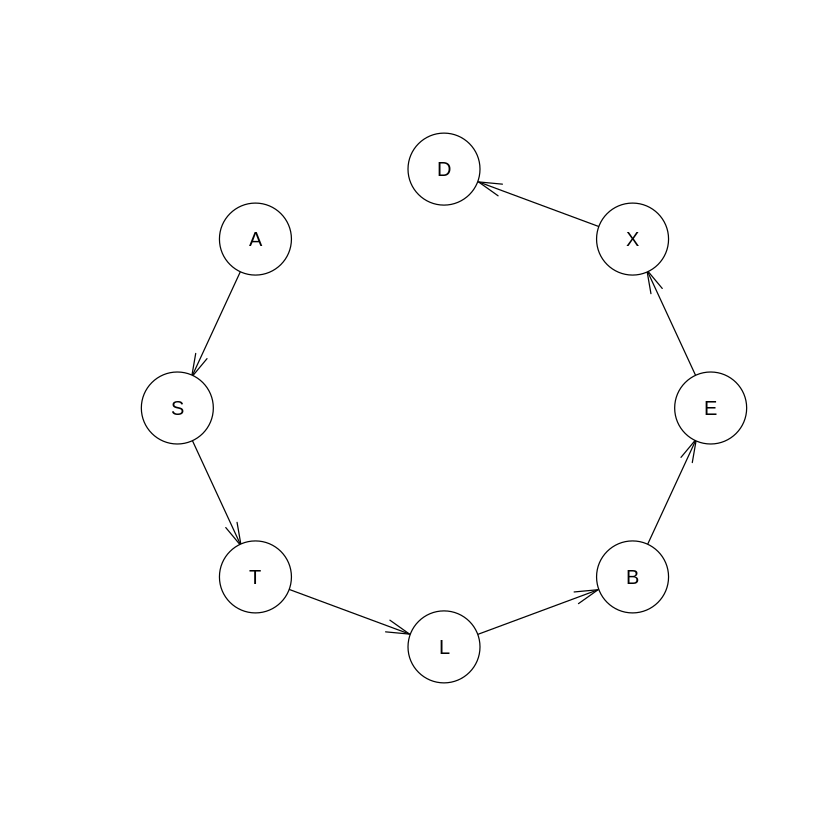

In [79]:
plot(dag)

### Network structure learning

The user creates a network and then codes their confidence in the network and inputs the data. The algorithm then estimates the most likely model structure. Two possible score-based algorithms in bnlearn: Hill Climbing (HC) and Tabu Search (Tabu). By comparison, in constraing-based structure learning, there is no initial model structure provided. There are also hybrid methods.

In [80]:
# E.g. of constraint-based
iambex = iamb(asia)
iambex


  Bayesian network learned via Constraint-based methods

  model:
   [A][S][T][L][X][D][B|S:D][E|T:L] 
  nodes:                                 8 
  arcs:                                  4 
    undirected arcs:                     0 
    directed arcs:                       4 
  average markov blanket size:           1.50 
  average neighbourhood size:            1.00 
  average branching factor:              0.50 

  learning algorithm:                    IAMB 
  conditional independence test:         Mutual Information (disc.) 
  alpha threshold:                       0.05 
  tests used in the learning procedure:  173 


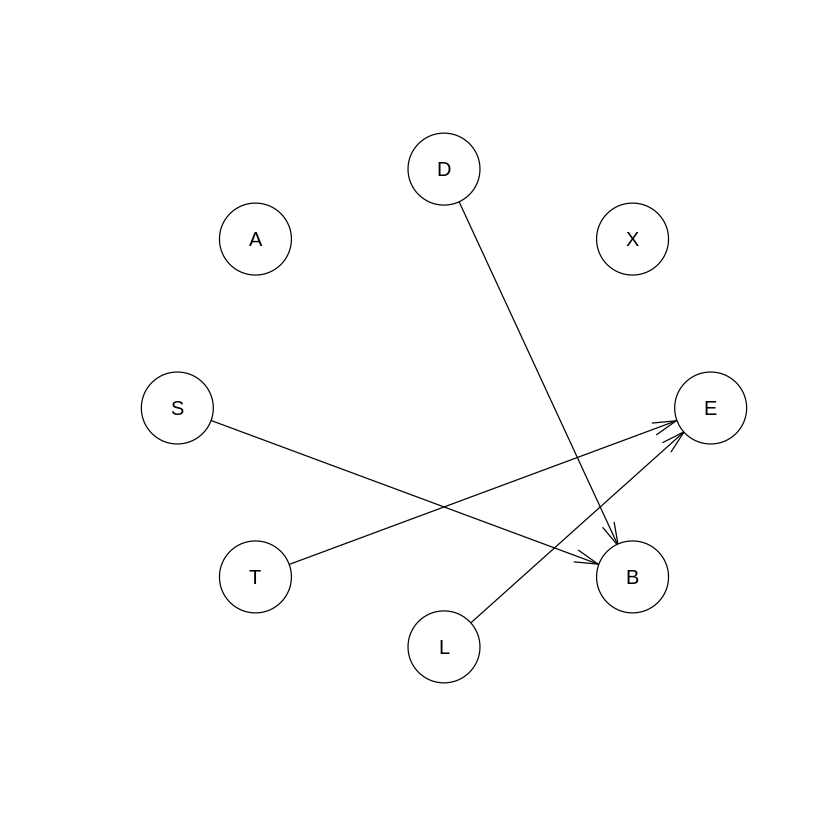

In [81]:
plot(iambex)

In [82]:
# E.g. of a score-based learning using the HC algorithm:
hcex = hc(asia)
hcex


  Bayesian network learned via Score-based methods

  model:
   [A][S][T][L|S][B|S][E|T:L][X|E][D|B:E] 
  nodes:                                 8 
  arcs:                                  7 
    undirected arcs:                     0 
    directed arcs:                       7 
  average markov blanket size:           2.25 
  average neighbourhood size:            1.75 
  average branching factor:              0.88 

  learning algorithm:                    Hill-Climbing 
  score:                                 BIC (disc.) 
  penalization coefficient:              4.258597 
  tests used in the learning procedure:  77 
  optimized:                             TRUE 


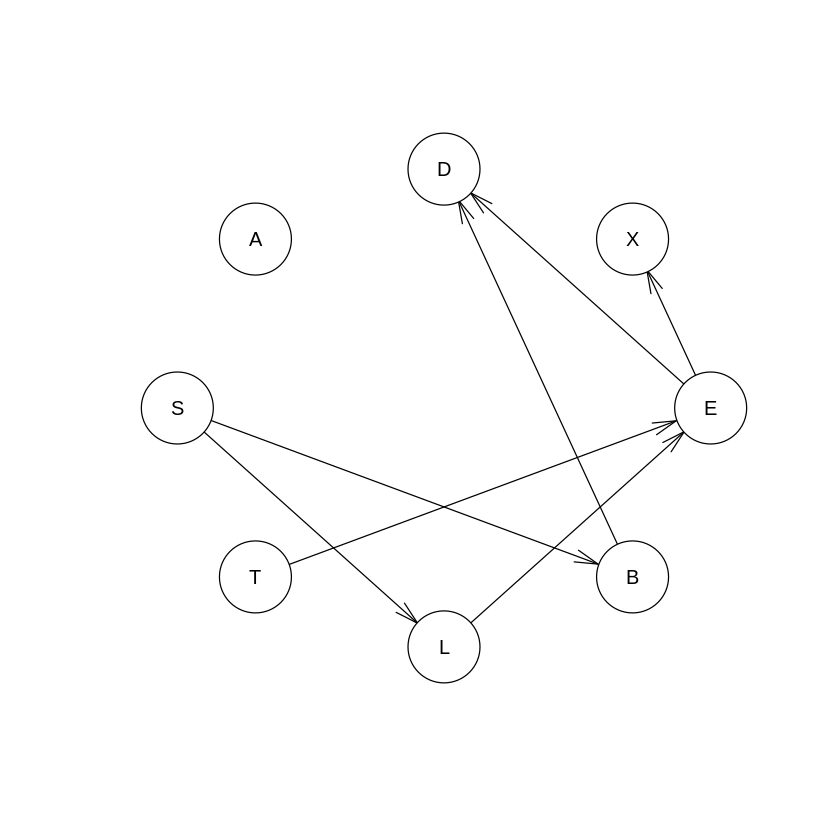

In [83]:
plot(hcex)

In [84]:
# Network scores
score(hcex, asia, type='aic')

[1] -11051.9

In [85]:
# Node 'A' is disconnected. Why? In true model, A influences T. What's the score between these nodes?
eq.net = set.arc(hcex, "A", "T") #Set arcs to get actual scores from individual relationships
eq.net1 = set.arc(hcex, "T", "A")
score(eq.net, asia, type="aic")

[1] -11051.09

### Parameter learning or 'training' the network
Use bn.fit command to generate parameter estimates for CPTs at each node. Default estimation method is maximum likelihood (mle). Can also do parameter estimation with Bayesian methods, but currently only with discrete data (not ordinal, continuous, ...).

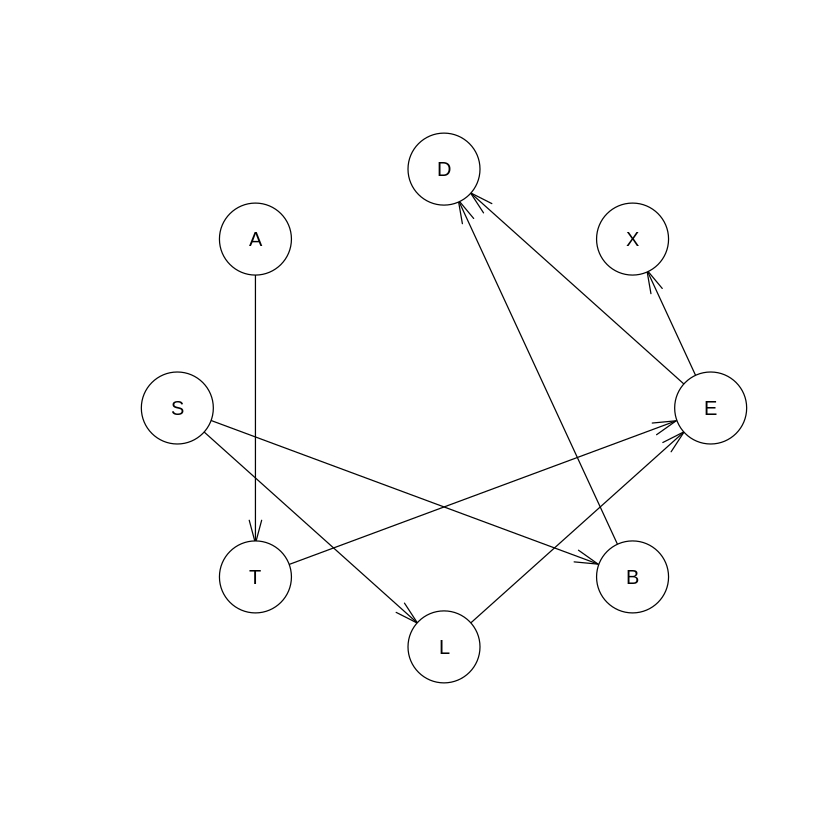

In [86]:
# Start with the hill climbing algorithm results, but add in an arc between A and T
hcex1 = set.arc(hcex, from="A", to="T") # Create a new DAG with the A-T relationship
plot(hcex1)

In [87]:
# Get node parameter estimates (n.b. can only use bayes method with discrete data.
# otherwise have to use default maximum likelihooe estimation, ie just delete method kwarg)
fit = bn.fit(hcex1, asia, method="bayes")
fit


  Bayesian network parameters

  Parameters of node A (multinomial distribution)

Conditional probability table:
        no       yes 
0.9915017 0.0084983 

  Parameters of node S (multinomial distribution)

Conditional probability table:
        no       yes 
0.4970006 0.5029994 

  Parameters of node T (multinomial distribution)

Conditional probability table:
 
     A
T              no         yes
  no  0.991479278 0.947058824
  yes 0.008520722 0.052941176

  Parameters of node L (multinomial distribution)

Conditional probability table:
 
     S
L             no        yes
  no  0.98622008 0.88223017
  yes 0.01377992 0.11776983

  Parameters of node B (multinomial distribution)

Conditional probability table:
 
     S
B            no       yes
  no  0.7005633 0.2823494
  yes 0.2994367 0.7176506

  Parameters of node E (multinomial distribution)

Conditional probability table:
 
, , L = no

     T
E               no          yes
  no  9.999730e-01 3.105590e-03
  yes 2.699638e-05 9.

In [88]:
# Retrieve cpt of a specific node using the $ operator
fit$L


  Parameters of node L (multinomial distribution)

Conditional probability table:
 
     S
L             no        yes
  no  0.98622008 0.88223017
  yes 0.01377992 0.11776983

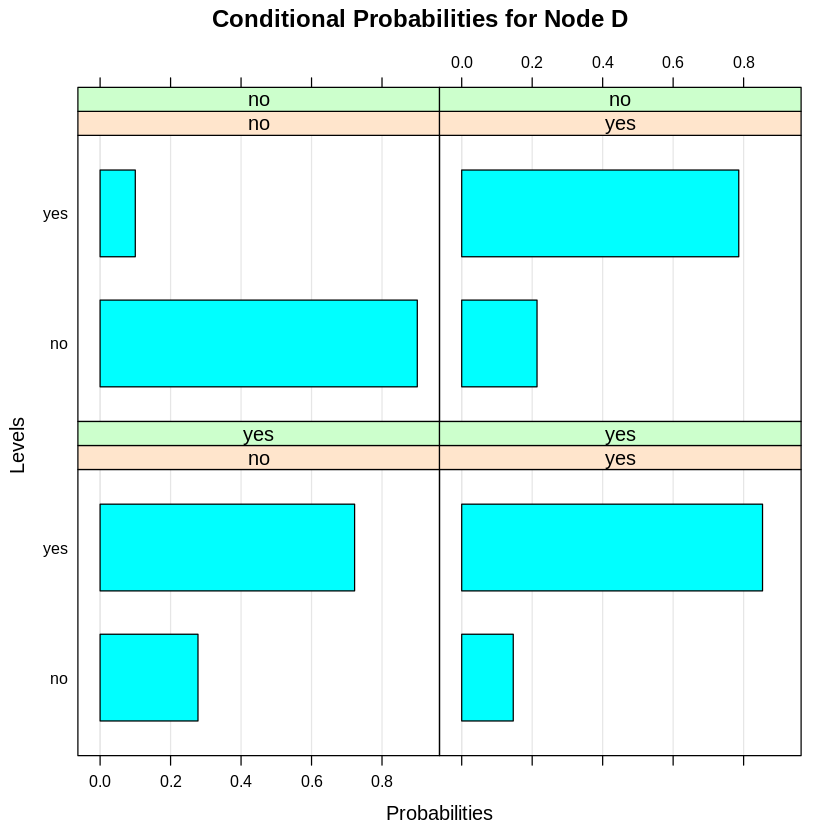

In [89]:
# Visualise the node CPTs with barcharts:
bn.fit.barchart(fit$D)

# Or with a dotplot, bn.fit.dotplot(fit$D)

### Model validation

Bnlearn has 3 methods for cross-validation: k-fold (default), custom, hold out. Example of k-fold here. A lower expected loss value is better, and compare structures derived from two learning algorithms, the Max-Min Hill Climb (mmhc) and the HC.

In [90]:
bn.cv(asia, bn = "hc", algorithm.args = list(score = "bde", iss = 1))


  k-fold cross-validation for Bayesian networks

  target learning algorithm:             Hill-Climbing 
  number of folds:                       10 
  loss function:                         Log-Likelihood Loss (disc.) 
  expected loss:                         2.209896 


I get an error when I try to replace "hc" with "mmhc" or one of the other algorithms. Don't know why. Means can't compare methods. But could compare manually-inputted structures in this way (comparing the average loss over the runs).

### Inference

Once have structure and parameter estimates, can make inferences from the network.

In [142]:
# E.g. 1, from beginning to end: probability that your xray is yes when you've been to Asia
cpquery(fit, event = (X=='yes'), evidence = (A=='yes'), n=1000000)

[1] 0.1567287

In [141]:
# From end to beginning: probability of you having been to Asia if your xray is yes
# NOTE, this is stochastic - this and cpdist are based on Monte Carlo particle filters (?), so
# can return different outputs when rerun. To make output more similar, increase n from the default

set.seed(1) #As there is a random element, can set this for reproducibility
cpquery(fit, event = (A=="yes"), evidence = ( X=="yes"), n=1000000)

[1] 0.0115026

In [113]:
fit


  Bayesian network parameters

  Parameters of node A (multinomial distribution)

Conditional probability table:
        no       yes 
0.9915017 0.0084983 

  Parameters of node S (multinomial distribution)

Conditional probability table:
        no       yes 
0.4970006 0.5029994 

  Parameters of node T (multinomial distribution)

Conditional probability table:
 
     A
T              no         yes
  no  0.991479278 0.947058824
  yes 0.008520722 0.052941176

  Parameters of node L (multinomial distribution)

Conditional probability table:
 
     S
L             no        yes
  no  0.98622008 0.88223017
  yes 0.01377992 0.11776983

  Parameters of node B (multinomial distribution)

Conditional probability table:
 
     S
B            no       yes
  no  0.7005633 0.2823494
  yes 0.2994367 0.7176506

  Parameters of node E (multinomial distribution)

Conditional probability table:
 
, , L = no

     T
E               no          yes
  no  9.999730e-01 3.105590e-03
  yes 2.699638e-05 9.

## Have a go with continuous data

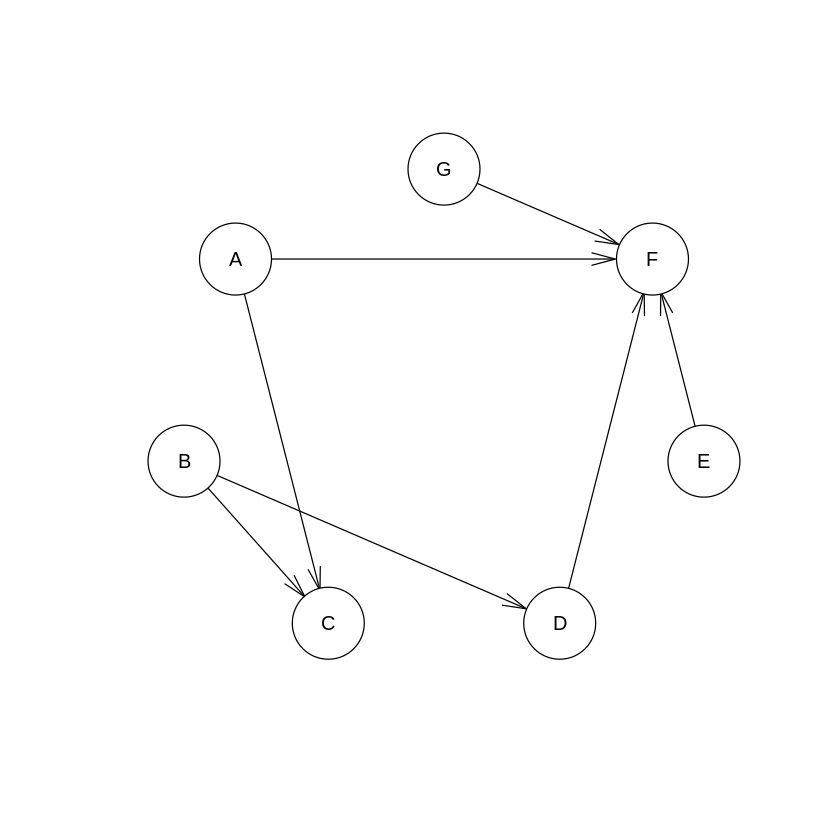

In [3]:
# load a test dataset that comes with bnlearn
data(gaussian.test)
# create and plot the network structure.
dag = model2network("[A][B][E][G][C|A:B][D|B][F|A:D:E:G]")
plot(dag)

In [8]:
# Fit parameters
fit = bn.fit(dag, gaussian.test)
fit


  Bayesian network parameters

  Parameters of node A (Gaussian distribution)

Conditional density: A
Coefficients:
(Intercept)  
   1.007493  
Standard deviation of the residuals: 1.004233 

  Parameters of node B (Gaussian distribution)

Conditional density: B
Coefficients:
(Intercept)  
   2.039499  
Standard deviation of the residuals: 3.034111 

  Parameters of node C (Gaussian distribution)

Conditional density: C | A + B
Coefficients:
(Intercept)            A            B  
   2.001083     1.995901     1.999108  
Standard deviation of the residuals: 0.5089772 

  Parameters of node D (Gaussian distribution)

Conditional density: D | B
Coefficients:
(Intercept)            B  
   5.995036     1.498395  
Standard deviation of the residuals: 0.3286672 

  Parameters of node E (Gaussian distribution)

Conditional density: E
Coefficients:
(Intercept)  
   3.493906  
Standard deviation of the residuals: 1.98986 

  Parameters of node F (Gaussian distribution)

Conditional density: F |

In [6]:
# Nodes A, B, G and E are independent. Can see that their 'coefficient' is the column mean
colMeans(gaussian.test, na.rm = FALSE, dims = 1)

# For child nodes, coefficients are the regression coefficients for the variable against its parents

A         B         C         D         E         F         G 
 1.007493  2.039499  8.089118  9.051011  3.493906 22.122517  5.028076

In [9]:
#The functions coefficients(), fitted() and residuals() allow extraction of the quantities of interest from a single variable or the whole network.
coefficients(fit$F)

(Intercept)            A            D            E            G 
-0.006047321  1.994853041  1.005636909  1.002577002  1.494373265

Loading required namespace: lattice


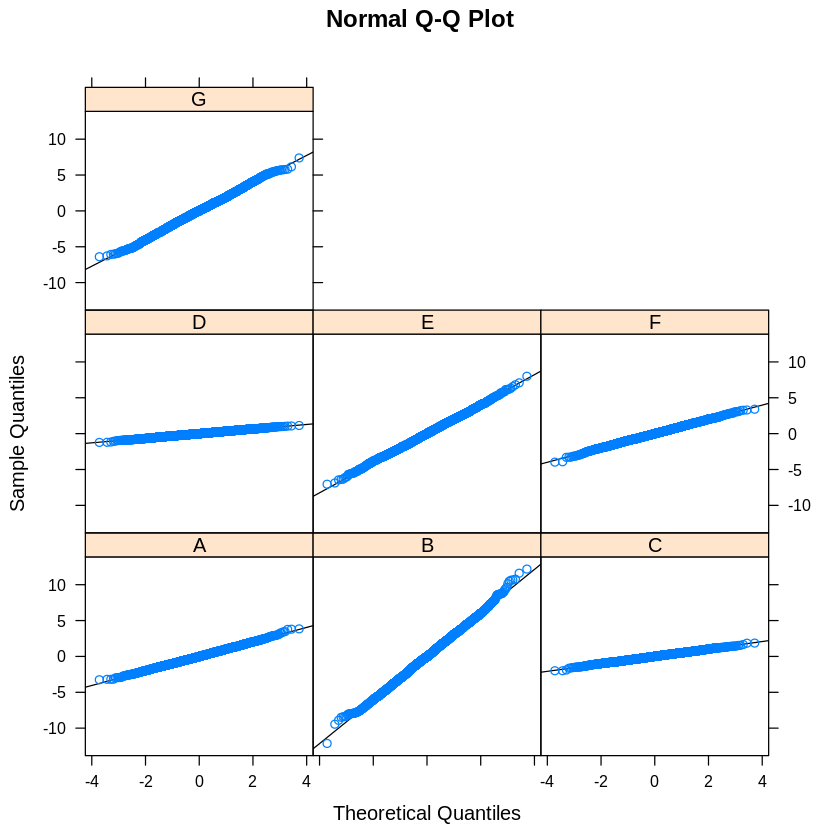

In [10]:
# Functions to plot these quantities: bn.fit.qqplot(), bn.fit.xyplot() and bn.fit.histogram()
# Can do single node plots as in the discrete network case. But can also plot all the nodes in a single plot.
bn.fit.qqplot(fit) # QQ plot of the residuals

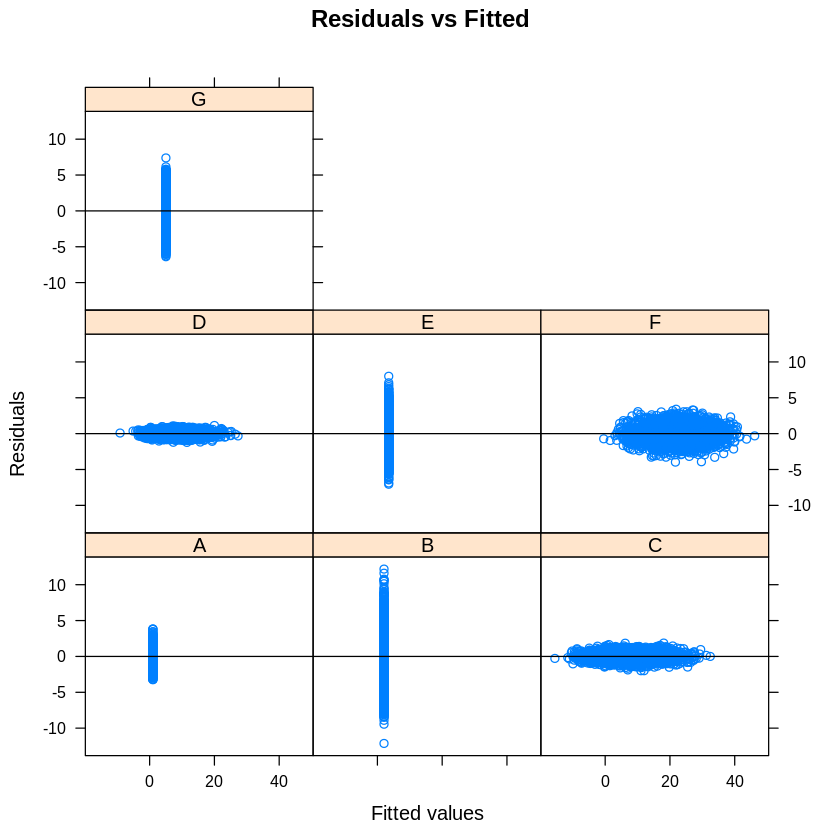

In [11]:
bn.fit.xyplot(fit)

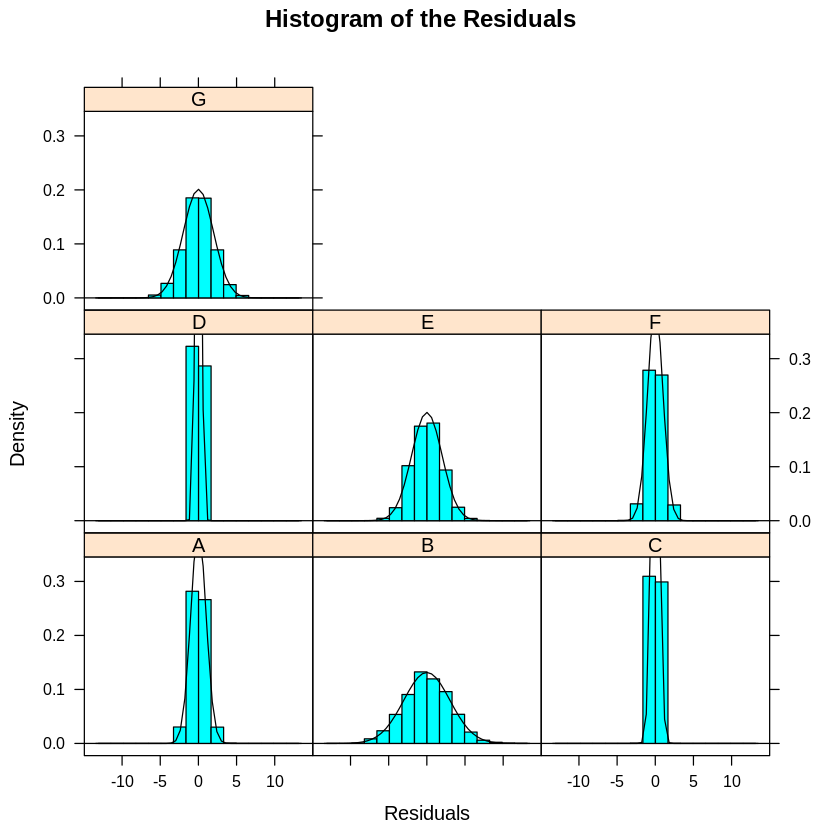

In [12]:
bn.fit.histogram(fit)

## Hybrid networks (mix of continuous and discrete data)

Discrete nodes can only have other discrete nodes as parents. Continuous nodes can have discrete parents. In this case, there's one regression coefficient for each configuration of the states of the discrete parent nodes.

i.e it's a bit limited, and probably not relevant for what I want. However, useful to see what the data looks like


In [15]:
head(clgaussian.test)

A,B,C,D,E,F,G,H
a,b,d,6.460721,11.98657,b,34.84246,2.334846
b,a,a,12.758389,30.43674,b,106.63596,2.359112
b,c,c,12.175140,17.21532,a,68.92951,2.319435
b,c,d,12.006609,14.41646,b,86.17521,2.417494
b,a,a,12.328071,30.39631,b,103.58541,2.268150
b,c,c,12.613419,15.19344,b,90.84664,2.308369


i.e. if I'm going to discretize my data, and it be automatically recognised as such, need to use characters for the different classes. I can't see anything in the documentation about ordinal data (i.e. order between the classes)